 ______  ___     ______                        _________
___   |/  /________  /_______ _______ ______________  /
__  /|_/ /_  __ \_  __ \  __ `/_  __ `__ \  _ \  __  / 
_  /  / / / /_/ /  / / / /_/ /_  / / / / /  __/ /_/ /  
/_/  /_/  \____//_/ /_/\__,_/ /_/ /_/ /_/\___/\__,_/   
                                                       
_____________ _________      ___________        _________            
___    |__  /_______  /_____ ___  /__  /_______ ______  /____________
__  /| |_  __ \  __  /_  __ `/_  /__  //_/  __ `/  __  /_  _ \_  ___/
_  ___ |  /_/ / /_/ / / /_/ /_  / _  ,<  / /_/ // /_/ / /  __/  /    
/_/  |_/_.___/\__,_/  \__,_/ /_/  /_/|_| \__,_/ \__,_/  \___//_/     
                                                                     



# Task
#### Cluster wine dataset using kmean and Agglomerative with a good visualization

## 1. Import Libraries

In [2]:
import os
import warnings
warnings.filterwarnings('ignore') 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.cluster import hierarchy
from scipy.spatial import distance_matrix
from yellowbrick.cluster import KElbowVisualizer

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

## 2. Read Data

In [3]:
data = pd.read_csv('wine-clustering.csv')
data.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Alcohol               178 non-null    float64
 1   Malic_Acid            178 non-null    float64
 2   Ash                   178 non-null    float64
 3   Ash_Alcanity          178 non-null    float64
 4   Magnesium             178 non-null    int64  
 5   Total_Phenols         178 non-null    float64
 6   Flavanoids            178 non-null    float64
 7   Nonflavanoid_Phenols  178 non-null    float64
 8   Proanthocyanins       178 non-null    float64
 9   Color_Intensity       178 non-null    float64
 10  Hue                   178 non-null    float64
 11  OD280                 178 non-null    float64
 12  Proline               178 non-null    int64  
dtypes: float64(11), int64(2)
memory usage: 18.2 KB


In [5]:
data.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
Alcohol,178.000000,13.000618,0.811827,11.030000,12.362500,13.050000,13.677500,14.830000
Malic_Acid,178.000000,2.336348,1.117146,0.740000,1.602500,1.865000,3.082500,5.800000
Ash,178.000000,2.366517,0.274344,1.360000,2.210000,2.360000,2.557500,3.230000
Ash_Alcanity,178.000000,19.494944,3.339564,10.600000,17.200000,19.500000,21.500000,30.000000
Magnesium,178.000000,99.741573,14.282484,70.000000,88.000000,98.000000,107.000000,162.000000
Total_Phenols,178.000000,2.295112,0.625851,0.980000,1.742500,2.355000,2.800000,3.880000
Flavanoids,178.000000,2.029270,0.998859,0.340000,1.205000,2.135000,2.875000,5.080000
Nonflavanoid_Phenols,178.000000,0.361854,0.124453,0.130000,0.270000,0.340000,0.437500,0.660000
Proanthocyanins,178.000000,1.590899,0.572359,0.410000,1.250000,1.555000,1.950000,3.580000
Color_Intensity,178.000000,5.058090,2.318286,1.280000,3.220000,4.690000,6.200000,13.000000


<Axes: >

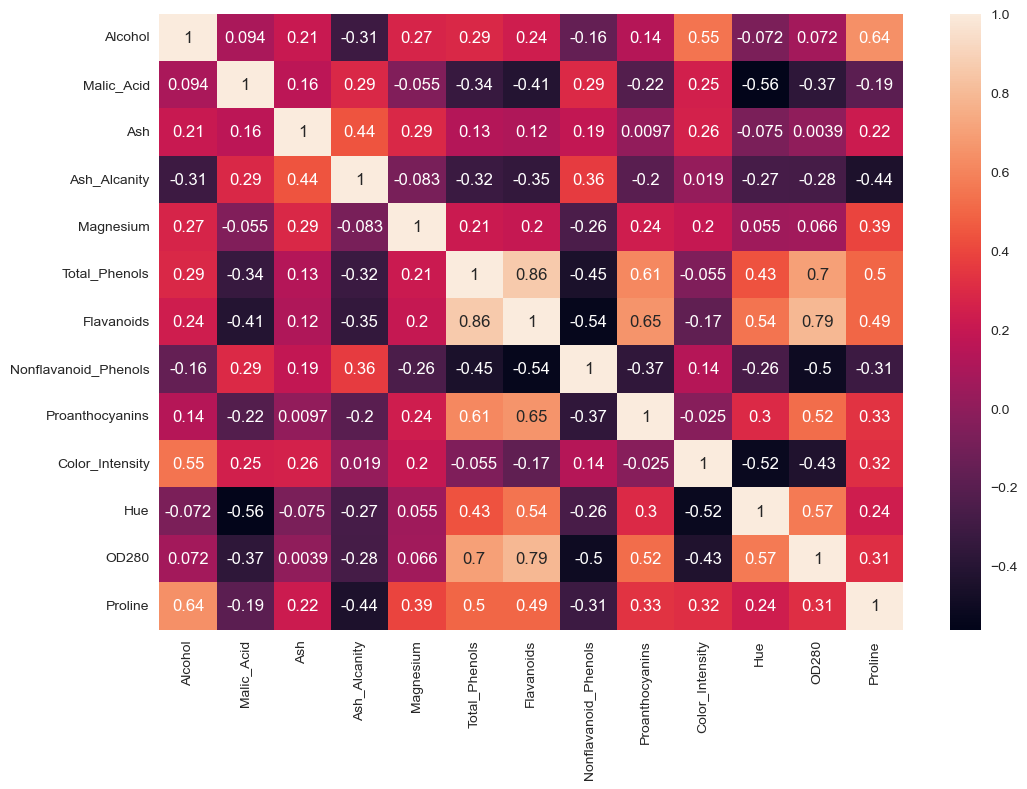

In [6]:
plt.subplots(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True)

## 3. Data Preprocessing

### 3.1 Detect Outliers

#### 3.1.1 IQR

In [7]:
def get_outliers(col, data = data):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    iqr_outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    
    return lower_bound, upper_bound, len(iqr_outliers)

for col in data.columns:
    lower_bound, upper_bound, outliers = get_outliers(col)
    print(f"Number of outliers detected based on IQR method ({str(col).center(20)}) : ", str(outliers).rjust(2), f" | Lower = {str(round(lower_bound, 5)).rjust(7)}", f" -> Upper = {str(round(upper_bound, 2)).rjust(7)}")        

Number of outliers detected based on IQR method (      Alcohol       ) :   0  | Lower =   10.39  -> Upper =   15.65
Number of outliers detected based on IQR method (     Malic_Acid     ) :   3  | Lower = -0.6175  -> Upper =     5.3
Number of outliers detected based on IQR method (        Ash         ) :   3  | Lower = 1.68875  -> Upper =    3.08
Number of outliers detected based on IQR method (    Ash_Alcanity    ) :   4  | Lower =   10.75  -> Upper =   27.95
Number of outliers detected based on IQR method (     Magnesium      ) :   4  | Lower =    59.5  -> Upper =   135.5
Number of outliers detected based on IQR method (   Total_Phenols    ) :   0  | Lower = 0.15625  -> Upper =    4.39
Number of outliers detected based on IQR method (     Flavanoids     ) :   0  | Lower =    -1.3  -> Upper =    5.38
Number of outliers detected based on IQR method (Nonflavanoid_Phenols) :   0  | Lower = 0.01875  -> Upper =    0.69
Number of outliers detected based on IQR method (  Proanthocyanins   ) :

In [8]:
outliers_length =   len(data[(data["Malic_Acid"]      <= -0.6175) | (data["Malic_Acid"]      >= 5.3)|
                             (data["Ash"]             <= 1.68875) | (data["Ash"]             >= 3.08)|
                             (data["Ash_Alcanity"]    <= 10.75)   | (data["Ash_Alcanity"]    >= 27.95)|
                             (data["Magnesium"]       <= 59.5)    | (data["Magnesium"]       >= 135.5)|
                             (data["Proanthocyanins"] <= 0.2)     | (data["Proanthocyanins"] >= 3.0)|
                             (data["Color_Intensity"] <= -1.25)   | (data["Color_Intensity"] >= 10.67)|
                             (data["Hue"]             <= 0.27625) | (data["Hue"]             >= 1.63)])

print(f"Outliers = {round(outliers_length/len(data)*100, 2)}%")

Outliers = 9.55%


#### 3.1.1 Box Plot

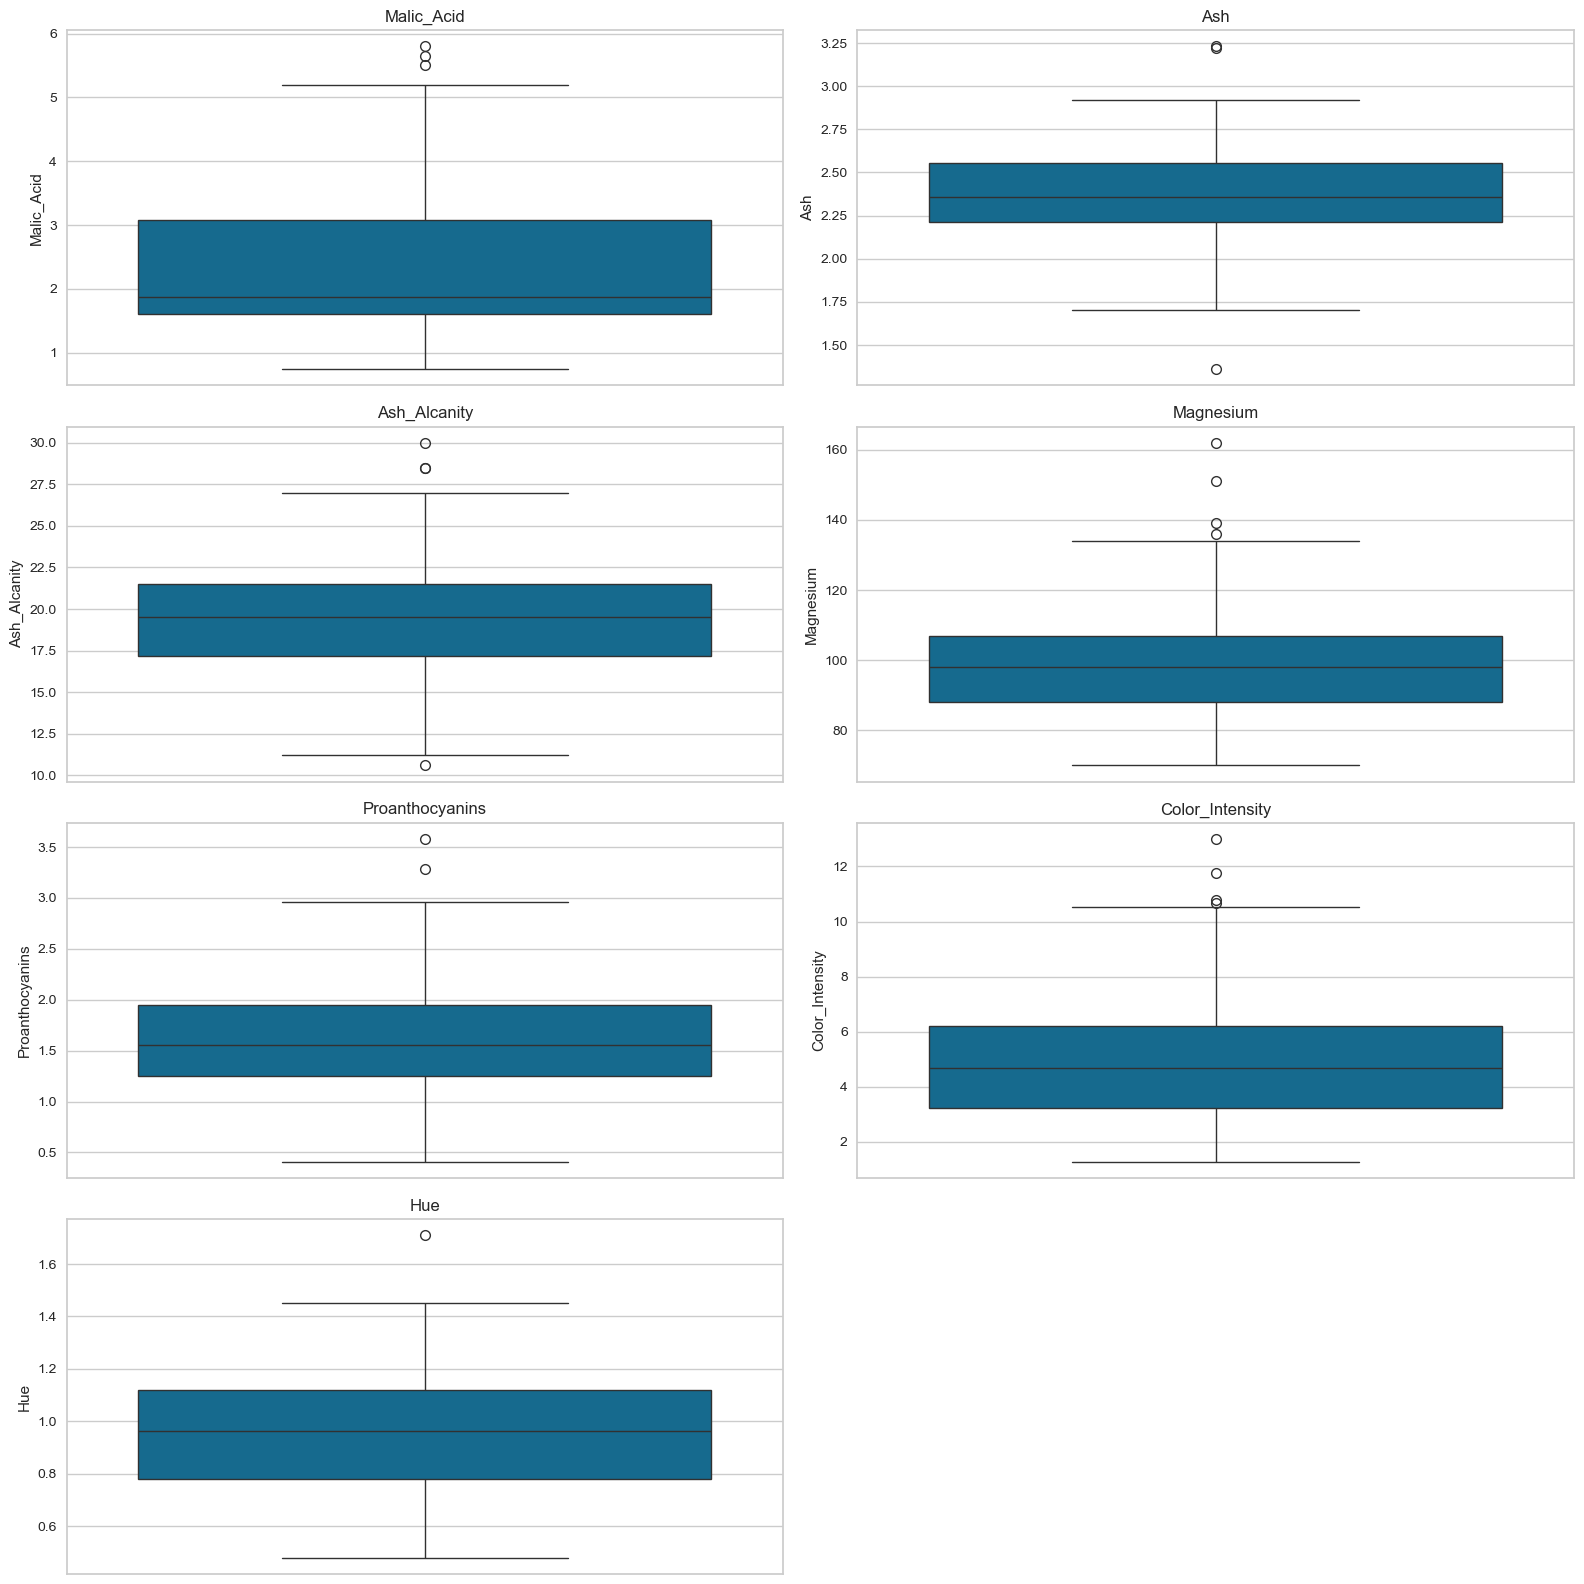

In [9]:
columns = ["Malic_Acid", "Ash", "Ash_Alcanity", "Magnesium", "Proanthocyanins", "Color_Intensity", "Hue"]

fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()  # Flatten the 4x2 array of axes to iterate easily

for i, column in enumerate(columns):
    sns.boxplot(ax=axes[i], y=data[column])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(column)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### 3.2 Data Scaling 

In [10]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

data[:5, :] # Sample

array([[ 1.51861254, -0.5622498 ,  0.23205254, -1.16959318,  1.91390522,
         0.80899739,  1.03481896, -0.65956311,  1.22488398,  0.25171685,
         0.36217728,  1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, -2.49084714,  0.01814502,
         0.56864766,  0.73362894, -0.82071924, -0.54472099, -0.29332133,
         0.40605066,  1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, -0.2687382 ,  0.08835836,
         0.80899739,  1.21553297, -0.49840699,  2.13596773,  0.26901965,
         0.31830389,  0.78858745,  1.39514818],
       [ 1.69154964, -0.34681064,  0.4879264 , -0.80925118,  0.93091845,
         2.49144552,  1.46652465, -0.98187536,  1.03215473,  1.18606801,
        -0.42754369,  1.18407144,  2.33457383],
       [ 0.29570023,  0.22769377,  1.84040254,  0.45194578,  1.28198515,
         0.80899739,  0.66335127,  0.22679555,  0.40140444, -0.31927553,
         0.36217728,  0.44960118, -0.03787401]])

### 3.3 Dimensionality Reduction using PCA

#### 3.3.1 Fitting Data to PCA Function

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data2 = pd.DataFrame(pca.fit_transform(data), columns=['PC1', 'PC2']) 
data2.head()

,PC1,PC2
0,3.316751,-1.443463
1,2.209465,0.333393
2,2.516740,-1.031151
3,3.757066,-2.756372
4,1.008908,-0.869831


#### 3.3.2 Visualizing PCA Output 

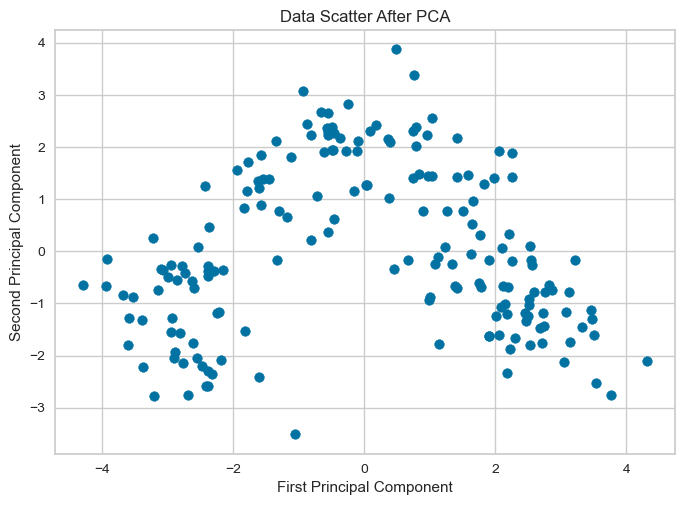

In [12]:
plt.scatter(data2['PC1'], data2['PC2'])
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.title(f"Data Scatter After PCA")
plt.show()

## 4. KMeans Clustering

### 4.1 Elbow Visualizer (to detect the optimal number of clusters )

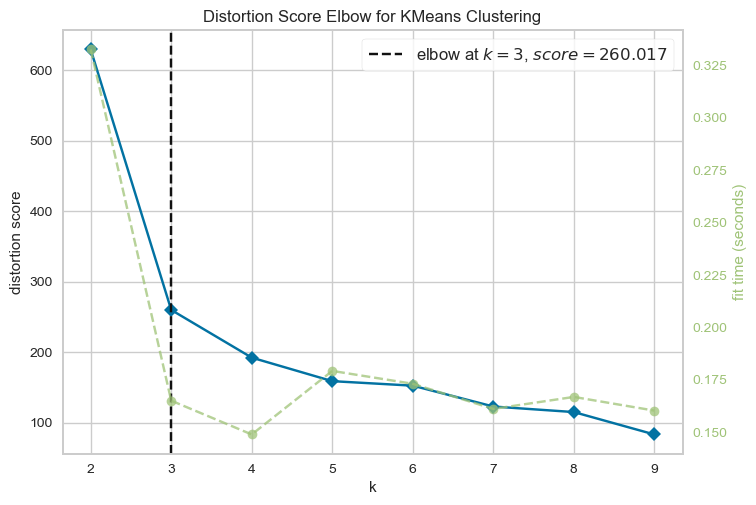

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
kMeans_Visualizing = KMeans(random_state=42)
visualizer = KElbowVisualizer(kMeans_Visualizing, k=(2, 10))
 
visualizer.fit(data2)
visualizer.show() 

### 4.2 Modeling

#### 4.2.1 Model Training

In [14]:
kMeans3_model  = KMeans(n_clusters=3).fit(data2)
data2['Labels'] = kMeans3_model.labels_

#### 4.2.2 Clusters Visualizing 

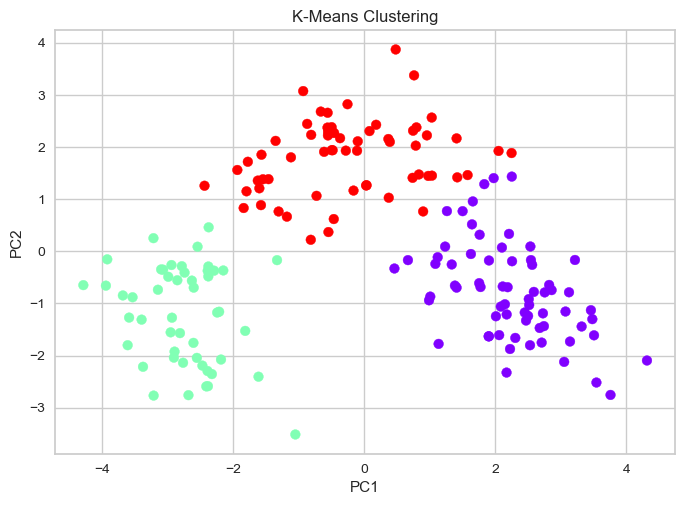

In [15]:
plt.scatter(data2['PC1'], data2['PC2'], c=data2['Labels'], cmap='rainbow')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-Means Clustering')
plt.show()

#### 4.2.3 Dendrogram

In [16]:
dist = distance_matrix(data2, data2)

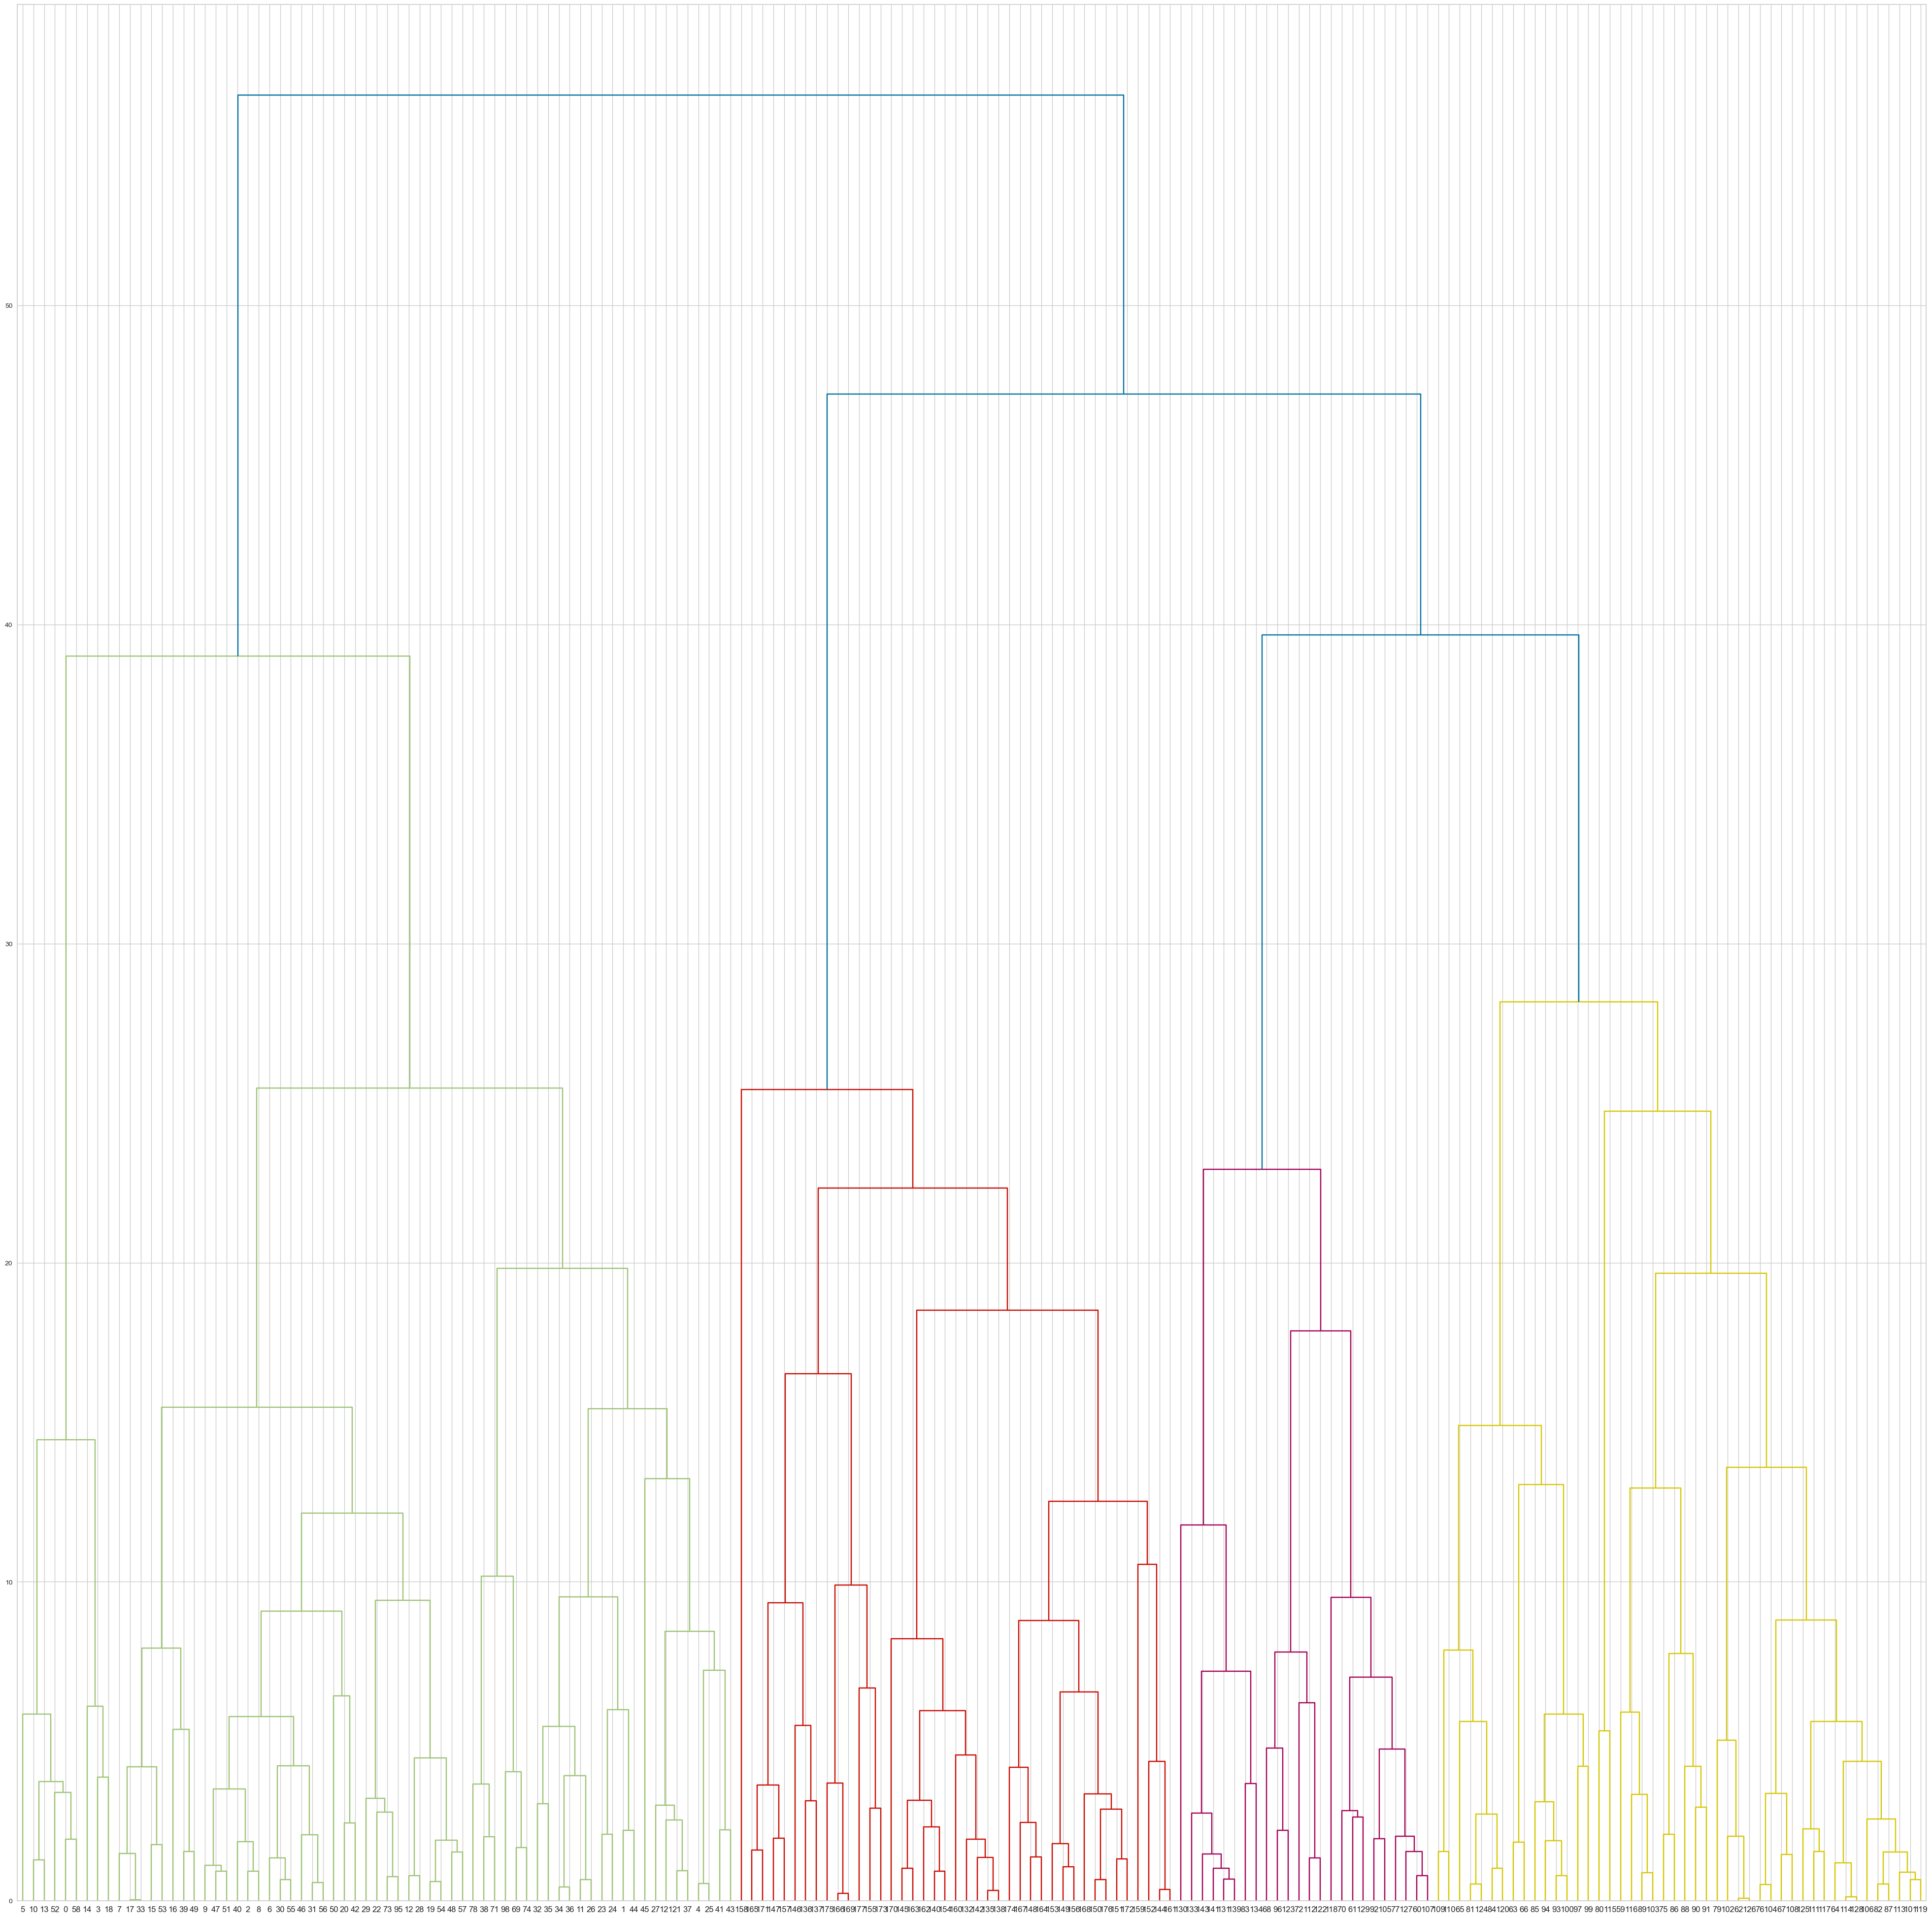

In [17]:
Z = hierarchy.linkage(dist, 'complete')
plt.figure(figsize=(50, 50))
dendro = hierarchy.dendrogram(Z, leaf_rotation=0, leaf_font_size=12, orientation='top')

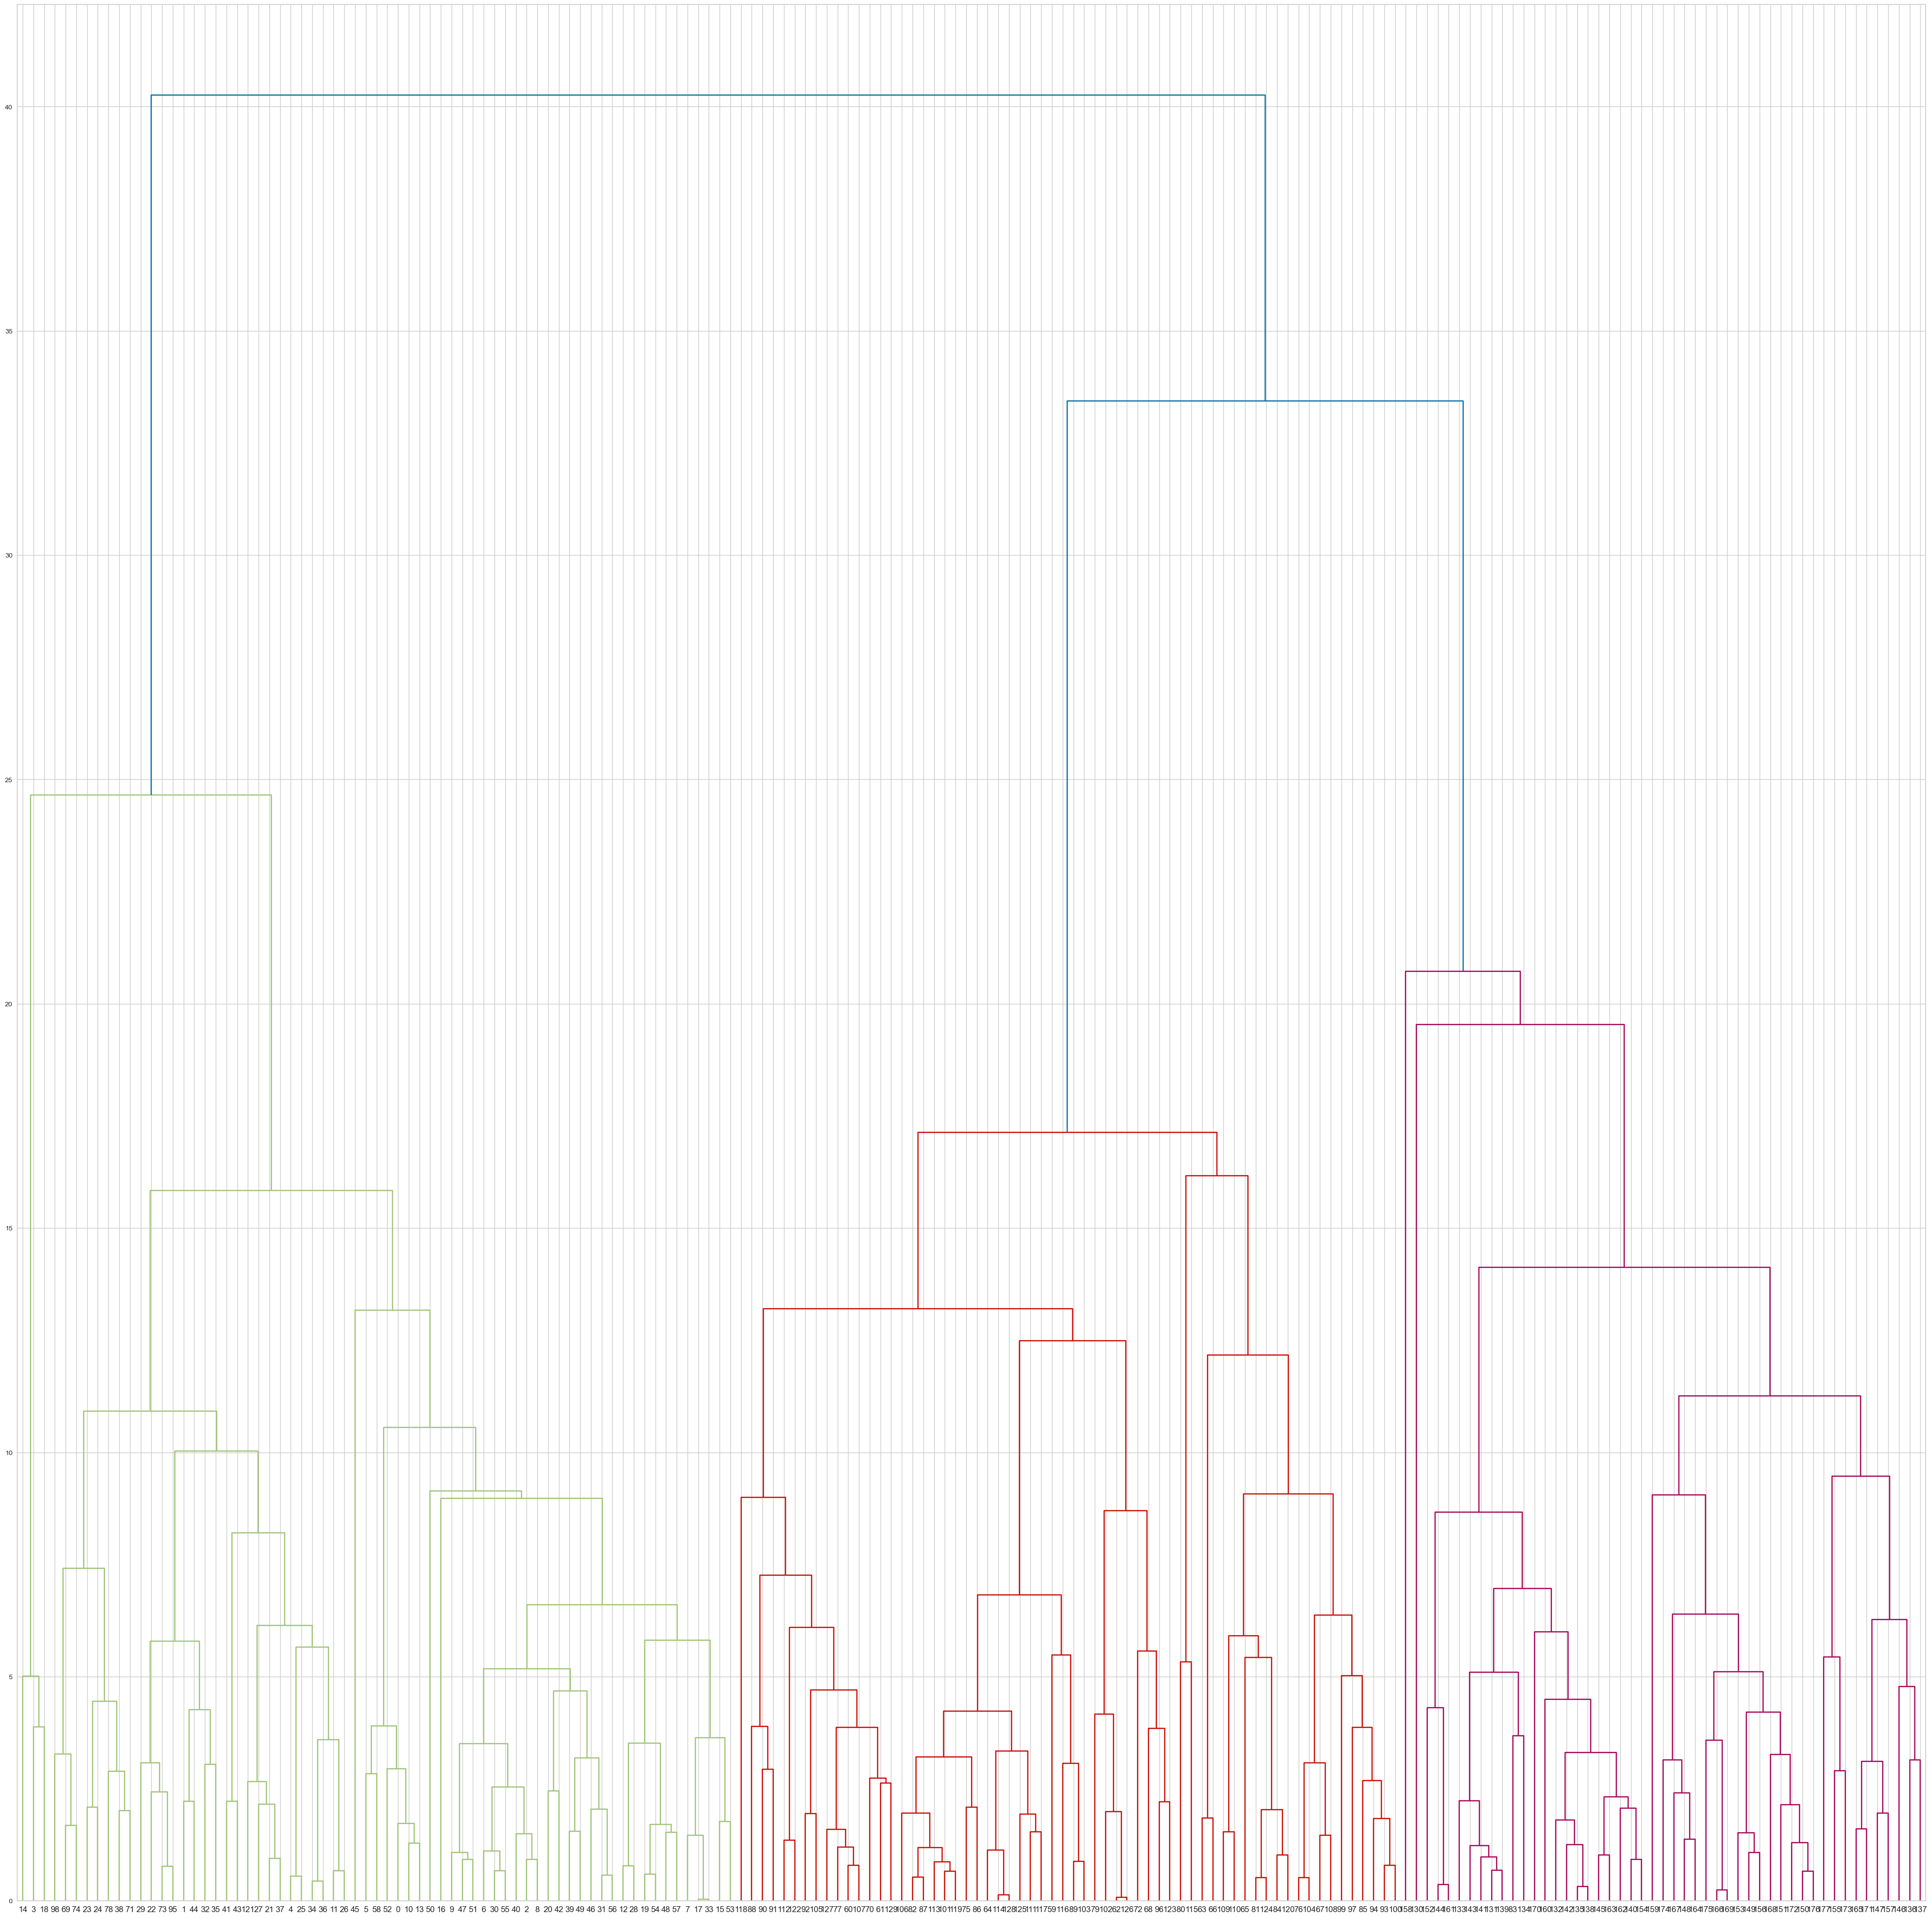

In [18]:
Z = hierarchy.linkage(dist, 'average')
plt.figure(figsize=(50, 50))
dendro = hierarchy.dendrogram(Z, leaf_rotation=0, leaf_font_size =12, orientation = 'top')